# Connectivity
**Objetive:** <br>
The following notebook creates infrastructure and connectivity maps. The connectivity data is from Ookla Open Data Initiative, data from 2023-Q1. The health infrastructure data is from official records for 10 countries (see Section 2) and healthsites.io<br>

**Notes:** <br>
If you have little to no experience with Python but want to produce maps for a different country or for the region, follow these steps: 
1. Change the variable `code` in section 3. 
    * For regional (LAC-26) results `code = "LAC"`. 
    * For country-level results, please use the iso alpha-3 codes in this [link](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3), and replace `code` with the country-code of interest. 
2. In the menu (upper left side of the notebook) go to `Run` and select `Run All Cells`.
3. In **preprocessing** you have to input whether you want the analysis using `public` or `official` records. After selecting option, the notebook would continue running. 
<br>
<br>

Author: Laura Goyeneche, Consultant SPH, lauragoy@iadb.org <br>
Created: Sept 19, 2023

## 1. Basics

In [1]:
# Library 
import os
import numpy as np
import pandas as pd
from shapely import wkt
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.ops import transform
from shapely.geometry import Point

In [2]:
%%capture
# Modules 
os.chdir(os.path.abspath('..'))
from src.utils import *
os.chdir(os.path.abspath('exercises'))

In [3]:
# Working environments
dotenv.load_dotenv()
sclbucket   = os.environ.get("sclbucket")
scldatalake = os.environ.get("scldatalake")

In [4]:
# Quantile labels function
def qcut_label(var, data):
    # Calculate quantiles and define labels
    qdf       = pd.qcut(data[var], q = 5)
    intervals = qdf.cat.categories 
    labels    = [
        f"Q1: < {intervals[0].right:.0f} Mbps",
        f"Q2: {intervals[0].right:.0f}-{intervals[1].right:.0f} Mbps",
        f"Q3: {intervals[1].right:.0f}-{intervals[2].right:.0f} Mbps",
        f"Q4: {intervals[2].right:.0f}-{intervals[3].right:.0f} Mbps",
        f"Q5: > {intervals[3].right:.0f} Mbps"
    ] 
    
    # Map intervals to labels
    qdf = qdf.cat.rename_categories(labels)
    
    return qdf

## 2. Inputs

In [5]:
# Shapefiles
shp0 = get_country_shp(level = 0)
shp1 = get_country_shp(level = 1)
shp2 = get_country_shp(level = 2)

In [6]:
# Connectivity
#path   = "Geospatial Basemaps/Connectivity"
#fixed  = gpd.read_file(f"{scldatalake}{path}/fixed/LAC-26/tiles/fixed_connectivity_2023_q4.shp")
#mobile = gpd.read_file(f"{scldatalake}{path}/mobile/LAC-26/tiles/mobile_connectivity_2023_q4.shp")

fixed  = gpd.read_file("fixed_connectivity_2023_q4.shp")
mobile = gpd.read_file("mobile_connectivity_2023_q4.shp")

In [7]:
%%capture 
# Health infrastructure 
path     = "Geospatial infrastructure/Healthcare Facilities"
official = pd.read_csv(f"{scldatalake}{path}/healthcare_facilities_official.csv")
official = official.drop(columns = "Unnamed: 0")
public   = pd.read_csv(f"{scldatalake}{path}/healthcare_facilities_public.csv")
public   = public.drop(columns = "Unnamed: 0")
public   = public[~public.amenity.isin(["doctors"])]

In [8]:
# List of countries with official records 
official.isoalpha3.unique().tolist()

['ARG',
 'BOL',
 'BRA',
 'CHL',
 'COL',
 'DOM',
 'ECU',
 'GTM',
 'GUY',
 'HTI',
 'HND',
 'JAM',
 'MEX',
 'PER',
 'SLV',
 'TTO']

## 3. Country of interest
Select country isoalpha-3 code based on `codes` list. If analysis for LAC, please replaces `code = "LAC"`

In [9]:
# LAC-26 codes 
data  = get_iadb()
codes = data.isoalpha3.tolist()

In [10]:
# Define country of interest
code = "LAC"

## 4. Preprocessing

In [11]:
# Filter shapefiles 
if code != "LAC":
    shp0 = shp0[shp0.ADM0_PCODE == code]
    shp1 = shp1[shp1.ADM0_PCODE == code]
    shp2 = shp2[shp2.ADM0_PCODE == code]

In [12]:
# Select health infrastructure 
if code in official.isoalpha3.unique():
    group = ""
    while group not in ["official","public"]:
        group = input("\nIf you've selected LAC, please indicate if the analysis should be based on 'official' or 'public' records? ")
        if group == "public":
            healthinfra_lab = "healthsites.io" 
            healthinfra = public[public.isoalpha3 == code]
        else:
            healthinfra_lab = "official records" 
            healthinfra = official[official.isoalpha3 == code]
else:
    if code != "LAC":
        healthinfra_lab = "healthsites.io" 
        healthinfra     = public[public.isoalpha3 == code]
    else: 
        group = ""
        while group not in ["official","public"]:
            group = input("\nIf you've selected LAC, please indicate if the analysis should be based on 'official' or 'public' records? ")
            if group == "public":
                healthinfra_lab = "healthsites.io" 
                healthinfra = public
            else:
                healthinfra_lab = "official records" 
                healthinfra = official


If you've selected LAC, please indicate if the analysis should be based on 'official' or 'public' records? official


In [13]:
# Omit infra with NA
healthinfra = healthinfra[~healthinfra.lat.isna()]
healthinfra = healthinfra[~healthinfra.lon.isna()]

In [14]:
# Convert health lat-lon data to GeoDataFrame
geometry    = gpd.points_from_xy(healthinfra['lon'], healthinfra['lat'])
healthinfra = gpd.GeoDataFrame(healthinfra.copy(), geometry = geometry, crs = 4326)

In [15]:
%%capture 
# Calculate buffer of 5 km around health centers
    # Reproject geometry
crs_ = healthinfra.crs
healthinfra = healthinfra.to_crs('EPSG:3857')

    # Calculate buffer in meters (5km)
distance = 5000
healthinfra["geometry"] = healthinfra.geometry.buffer(distance)

    # Reproject 
healthinfra = healthinfra.to_crs(crs_)

In [16]:
# Calculate speed in mbps
fixed ['avg_d_mbps'] = fixed ['avg_d_kbps'] / 1000
fixed ['avg_u_mbps'] = fixed ['avg_u_kbps'] / 1000
mobile['avg_d_mbps'] = mobile['avg_d_kbps'] / 1000
mobile['avg_u_mbps'] = mobile['avg_u_kbps'] / 1000

In [17]:
# Select connectivity points in country of interest
if code != "LAC":
    fixed_  = fixed [fixed .ADM0_PCODE == code]
    mobile_ = mobile[mobile.ADM0_PCODE == code]
else: 
    fixed_  = fixed
    mobile_ = mobile

In [18]:
%%time
# Identify healthcenters with connectivity points nearby 
hc_mobile = gpd.sjoin(healthinfra, mobile_)
hc_mobile = hc_mobile.groupby("source_id").apply(
    lambda x: pd.Series({
        "avg_d_mbps_mob": np.average(x['avg_d_mbps'], weights=x['tests']),
        "avg_u_mbps_mob": np.average(x['avg_u_mbps'], weights=x['tests'])
    })
).reset_index()

<timed exec>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


CPU times: user 42.4 s, sys: 2.31 s, total: 44.7 s
Wall time: 44.6 s


In [19]:
%%time
# Identify healthcenters with connectivity points nearby 
hc_fixed = gpd.sjoin(healthinfra, fixed_)
hc_fixed = hc_fixed.groupby("source_id").apply(
    lambda x: pd.Series({
        "avg_d_mbps_fix": np.average(x['avg_d_mbps'], weights=x['tests']),
        "avg_u_mbps_fix": np.average(x['avg_u_mbps'], weights=x['tests'])
    })
).reset_index()

<timed exec>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


CPU times: user 49.1 s, sys: 3.3 s, total: 52.4 s
Wall time: 52.4 s


In [21]:
# Merge with health infrastructure data 
fhealthinfra = healthinfra .merge(hc_mobile, on = "source_id", how = "left")
fhealthinfra = fhealthinfra.merge(hc_fixed , on = "source_id", how = "left")

In [22]:
# Identifty hospitals without connectivity
fhealthinfra["conn_mob"] = np.where((fhealthinfra.avg_d_mbps_mob.isna()) | (fhealthinfra.avg_u_mbps_mob.isna()),0,1)
fhealthinfra["conn_fix"] = np.where((fhealthinfra.avg_d_mbps_fix.isna()) | (fhealthinfra.avg_u_mbps_fix.isna()),0,1)

In [23]:
# Convert health lat-lon data to GeoDataFrame
geometry     = gpd.points_from_xy(fhealthinfra['lon'], fhealthinfra['lat'])
fhealthinfra = gpd.GeoDataFrame(fhealthinfra.copy(), geometry = geometry, crs = 4326)

In [24]:
# Clip with regional boundaries
fhealthinfra = gpd.clip(fhealthinfra, shp0)

In [25]:
%%capture
# Save layer
fhealthinfra.to_file(f"health_facilities_{group}_connectivity.shp")

## 5. Maps

### 5.1. Health centers

In [58]:
# Results
print(f"Total number of health centers {fhealthinfra.shape[0]:,} in {code}")

Total number of health centers 248,797 in LAC


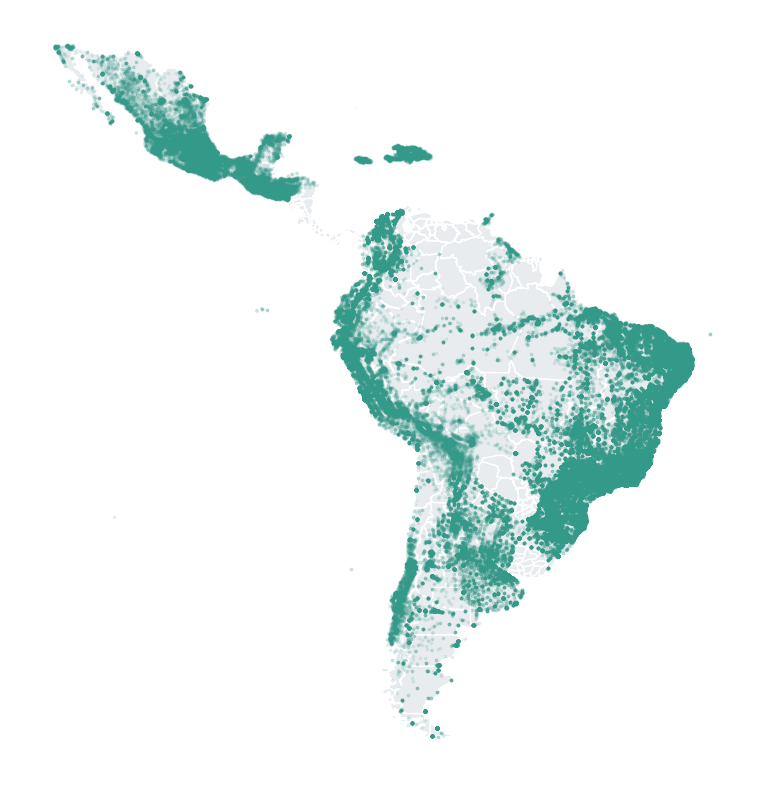

In [27]:
# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1.plot(ax = ax, color = "#e9ecef", linewidth  = 1, edgecolor = "white")
fhealthinfra.plot(ax = ax, color = "#339989", markersize = 3, alpha = .1)
ax.axis("off")
plt.show()

### 5.2. Mobile and fixed connectivity

#### Mobile connectivity

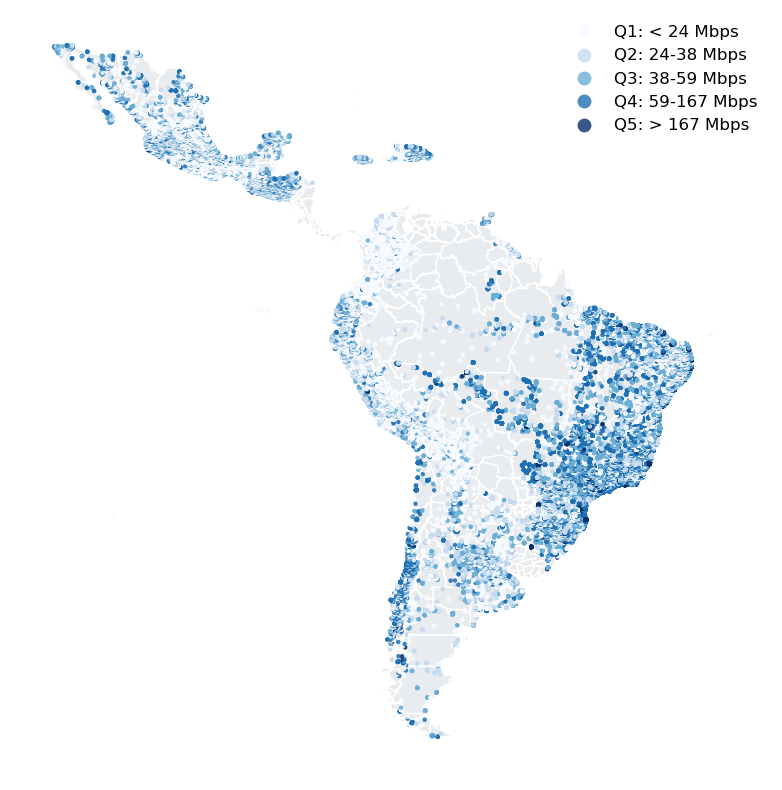

In [28]:
# Temporary variable
var_                = "avg_d_mbps_mob"
fhealthinfra["temp"] = qcut_label(var_, fhealthinfra)

# Map plot
fig, ax = plt.subplots(1, figsize = (10,10))
shp1.plot(ax = ax, color = "#e9ecef", linewidth  = 1, edgecolor = "white")
fhealthinfra.plot(ax = ax, column = "temp", cmap = "Blues", categorical = True, legend = True, alpha = 0.8, markersize = 5, legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.axis("off")
plt.show()

#### Fixed connectivity

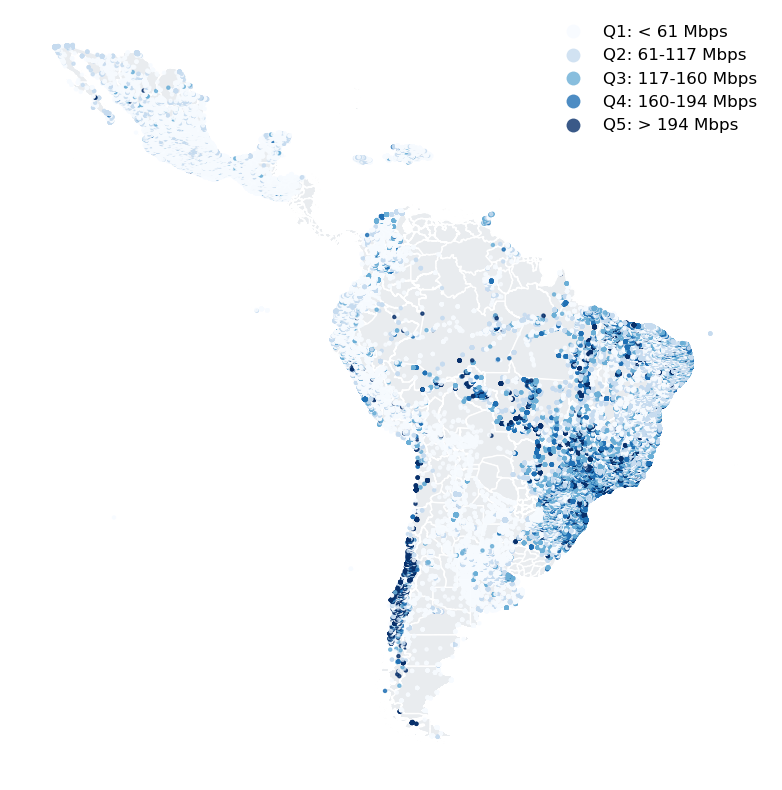

In [31]:
# Temporary variable
var_                 = "avg_d_mbps_fix"
fhealthinfra["temp"] = qcut_label(var_, fhealthinfra)

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth  = 1, edgecolor = "white")
fhealthinfra.plot(ax = ax, column = "temp", cmap = "Blues", categorical = True, legend = True, alpha = 0.8, markersize = 5, legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.axis("off")
plt.show()

#### With "Sin conectividad"

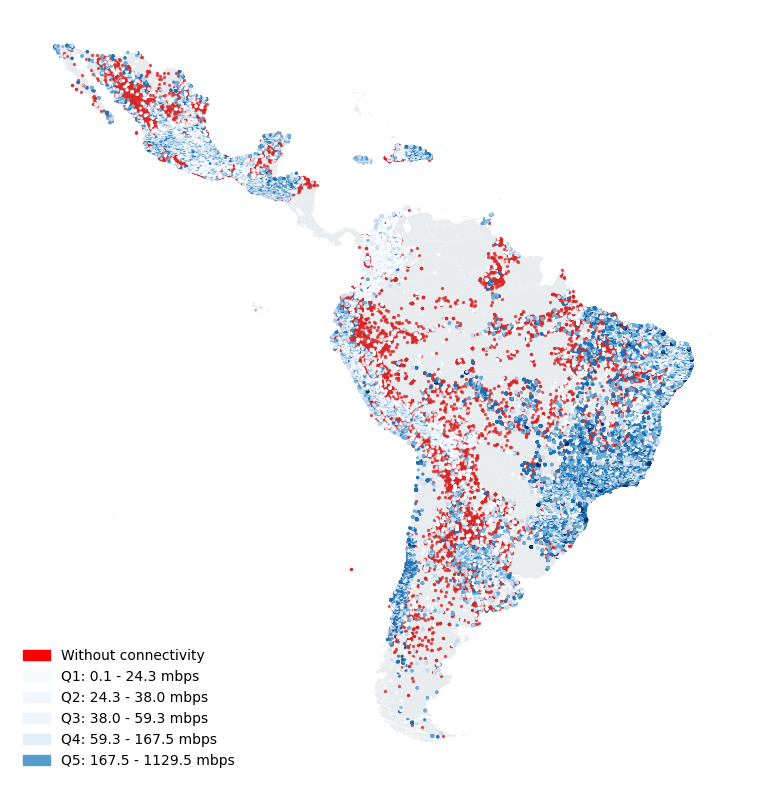

In [92]:
con_type     = "mobile"
var          = f"avg_d_mbps_{con_type[:3]}"
fhealthinfra[var] = np.where(fhealthinfra[var] < 0.1, np.nan, fhealthinfra[var])
temp         = fhealthinfra.copy()
temp['temp'] = np.where(temp[var].isna(), "Sin conectividad", None)
temp         = temp[temp.temp == "Sin conectividad"]

fig, ax = plt.subplots(1, figsize = (10,10))
shp1.plot(ax = ax, color = "#e9ecef", linewidth = .5)
temp.plot(ax = ax, color = "#d62828", markersize = 2, alpha = .7, legend = False)
fhealthinfra.plot(ax = ax, column = var, cmap  = "Blues", markersize = 2, alpha = .7, legend = False, scheme = "Quantiles", k = 5)

handles = []
legend1 = mpatches.Patch(color = "red", label = "Without connectivity")
handles.append(legend1)

cmap = plt.cm.Blues
norm = plt.Normalize(vmin = fhealthinfra[var].min(), vmax = fhealthinfra[var].max())
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm._A = []

qvals   = fhealthinfra[var].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
legend2 = [f'Q{n+1}: {qvals[i]:.1f} - {qvals[i+1]:.1f} mbps' for n,i in enumerate(range(len(qvals)-1))]

for i, label in enumerate(legend2):
    color  = cmap(norm((qvals[i] + qvals[i+1]) / 2)) 
    patch  = mpatches.Patch(color = color, label = label)
    handles.append(patch)

ax.legend(handles = handles, loc = 'lower left', frameon = False)
ax.axis('off')
plt.show()

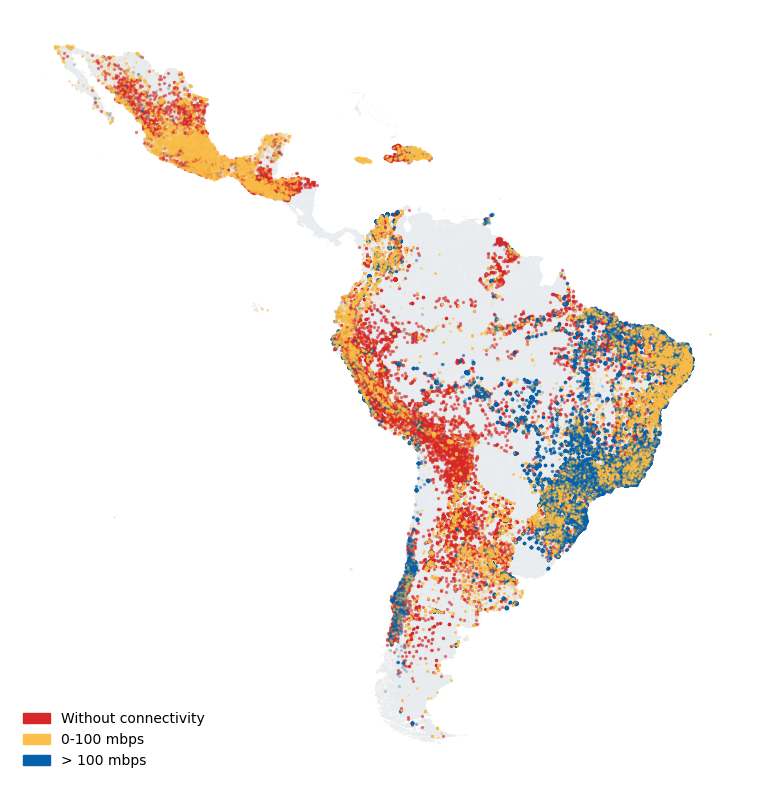

In [149]:
# Inputs
con_type  = "fixed"
var       = f"avg_d_mbps_{con_type[:3]}"
threshold = 100

# Without connecitivty
fhealthinfra[var] = np.where(fhealthinfra[var] < 0.1, np.nan, fhealthinfra[var])
temp1 = fhealthinfra.copy()
temp1['temp'] = np.where(temp1[var].isna(), "Sin conectividad", None)
temp1         = temp1[temp1.temp == "Sin conectividad"]

# < threshold 
temp2 = fhealthinfra.copy()
temp2['temp'] = np.where(temp2[var] <= threshold, 1, None)
temp2         = temp2[temp2.temp == 1]

# > threshold 
temp3 = fhealthinfra.copy()
temp3['temp'] = np.where(temp3[var] > threshold, 1, None)
temp3         = temp3[temp3.temp == 1]

# Map plot
fig, ax = plt.subplots(1, figsize = (10,10))
shp1 .plot(ax = ax, color = "#e9ecef", linewidth = .5)
temp1.plot(ax = ax, color = "#d62828", markersize = 2, alpha = .5, legend = False)
temp3.plot(ax = ax, color = "#0561ac", markersize = 2, alpha = .2, legend = False)
temp2.plot(ax = ax, color = "#fcbf49", markersize = .5, alpha = .2, legend = False)

    # Legend
legend1 = mpatches.Patch(color = "#d62828", label = "Without connectivity")
legend2 = mpatches.Patch(color = "#fcbf49", label = f"0-{threshold} mbps")
legend3 = mpatches.Patch(color = "#0561ac", label = f"> {threshold} mbps")
handles = [legend1, legend2, legend3]

ax.legend(handles = handles, loc = 'lower left', frameon = False)
ax.axis('off')
plt.show()

### 5.2. Health centers with or without connectivity (yes/no)

#### Mobile connectivity

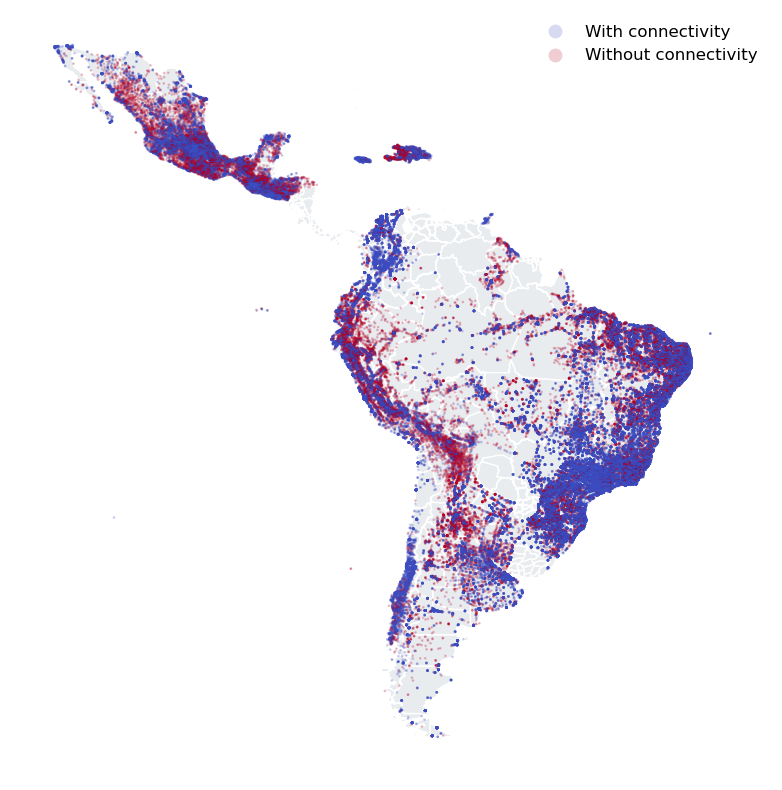

In [34]:
# Temporary variable
fhealthinfra["temp"] = np.where(fhealthinfra["conn_mob"] == 1, "With connectivity", "Without connectivity")

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1.plot(ax = ax, color = "#e9ecef", linewidth = 1, edgecolor = "white")
fhealthinfra.plot(ax = ax, column = "temp", cmap = "coolwarm", categorical = True, legend = True, alpha = 0.2, markersize = 1, legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.axis("off")
plt.show()

#### Fixed connectivity

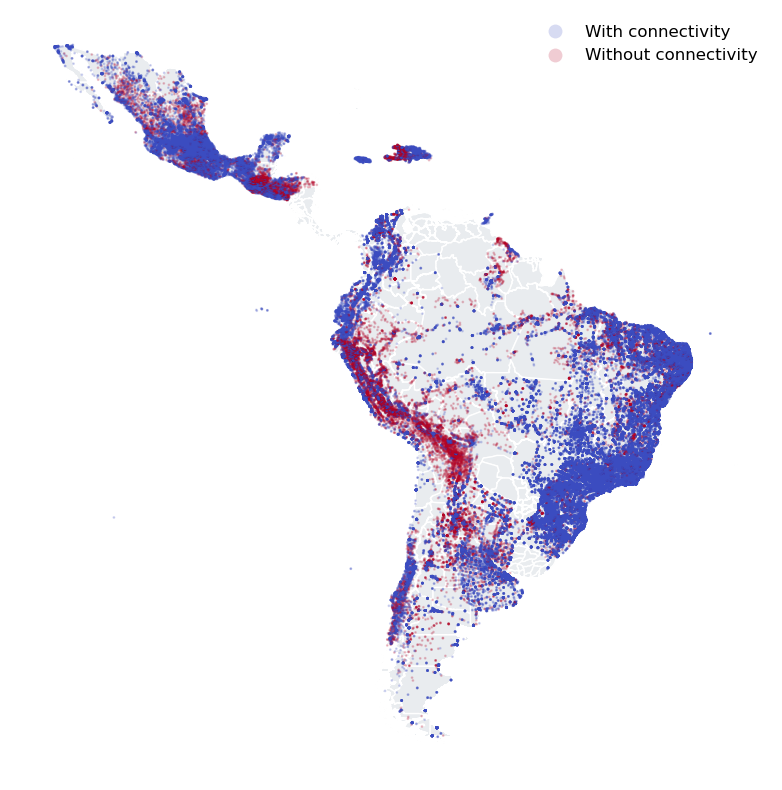

In [35]:
# Temporary variable
fhealthinfra["temp"] = np.where(fhealthinfra["conn_fix"] == 1, "With connectivity", "Without connectivity")

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth = 1, edgecolor = "white")
fhealthinfra.plot(ax = ax, column = "temp", cmap = "coolwarm", categorical = True, legend = True, alpha = 0.2, markersize = 1, legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.axis("off")
plt.show()

In [36]:
# Results
n_no_connec_mob = fhealthinfra.shape[0] - fhealthinfra.conn_mob.sum()
n_no_connec_fix = fhealthinfra.shape[0] - fhealthinfra.conn_fix.sum()
p_no_connec_mob = (n_no_connec_mob / healthinfra.shape[0]) * 100
p_no_connec_fix = (n_no_connec_fix / healthinfra.shape[0]) * 100

print(f"{n_no_connec_mob:,} ({p_no_connec_mob:.1f}%) health centers are located in areas without mobile connectivity")
print(f"{n_no_connec_fix:,} ({p_no_connec_fix:.1f}%) health centers are located in areas without fixed connectivity")
print(f"\nSource: Health centers from {healthinfra_lab} and connectivity data from Ookla Open Data Initiative, data from 2023-Q1")
print(f"Notes: A health center is considered to have connectivity if Ookla identifies at least one point with connectivity within a 5 km radius of the health center.")

25,060 (10.1%) health centers are located in areas without mobile connectivity
16,333 (6.6%) health centers are located in areas without fixed connectivity

Source: Health centers from official records and connectivity data from Ookla Open Data Initiative, data from 2023-Q1
Notes: A health center is considered to have connectivity if Ookla identifies at least one point with connectivity within a 5 km radius of the health center.


### 5.3. Health centers with low or high connectivity

#### Mobile connectivity

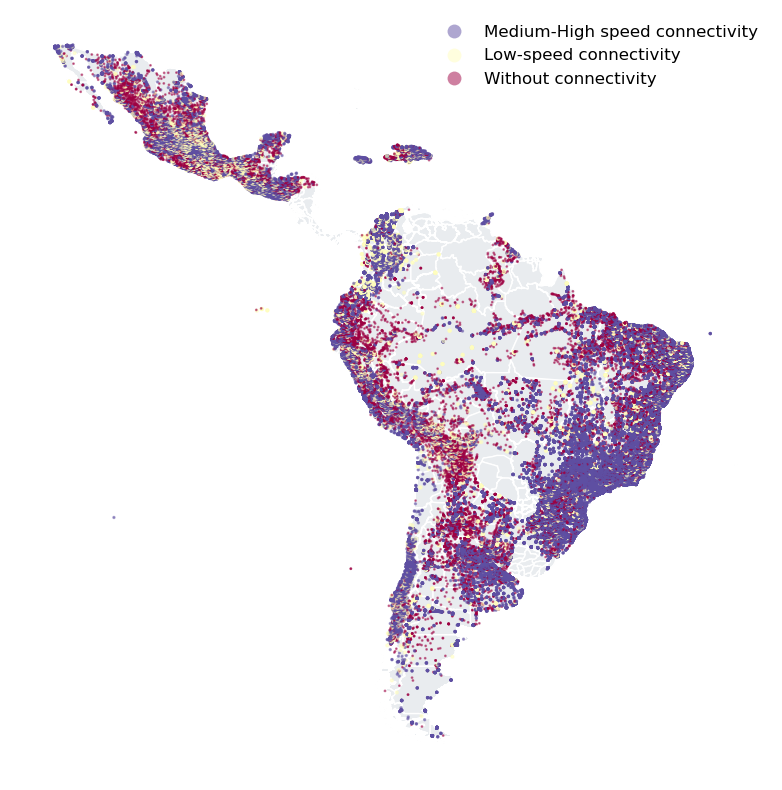

In [37]:
var_ = "avg_d_mbps_mob"
vmin = 10 
cats = ["Medium-High speed connectivity","Low-speed connectivity","Without connectivity"]

fhealthinfra["mtemp"] = np.where(fhealthinfra[var_].isna() , cats[2], "")
fhealthinfra["mtemp"] = np.where(fhealthinfra[var_] <= vmin, cats[1], fhealthinfra.mtemp)
fhealthinfra["mtemp"] = np.where(fhealthinfra[var_] >  vmin, cats[0], fhealthinfra.mtemp)
fhealthinfra["mtemp"] = pd.Categorical(fhealthinfra["mtemp"], categories = cats, ordered = True)

fhealthinfra["size_"] = np.where(fhealthinfra.mtemp == cats[2],1,0)
fhealthinfra["size_"] = np.where(fhealthinfra.mtemp == cats[1],4,fhealthinfra.size_)
fhealthinfra["size_"] = np.where(fhealthinfra.mtemp == cats[0],2,fhealthinfra.size_)

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth = 1, edgecolor = "white")
fhealthinfra.plot(ax = ax, column = "mtemp", cmap = "Spectral_r", categorical = True, legend = True, alpha = 0.5, markersize = "size_", legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.axis("off")
plt.show()

In [38]:
# Results 
main_ = fhealthinfra.mtemp.value_counts(dropna = False).reset_index()
main_ = main_.rename(columns = {"count":'# health centers'})
main_["% health centers"] = main_["# health centers"] * 100 / main_["# health centers"].sum()
low_high = main_[main_["mtemp"].isin(cats[:2])]["# health centers"].sum()
low_per  = main_[main_["mtemp"].isin(cats[1:2])]["# health centers"].sum() / low_high

print(main_)
print(" ")
print(f"Number of healthcenters with low-high speed: {low_high:,} of which {low_per*100:.1f}% have low-speed")

print(f"\nSource: Health centers from {healthinfra_lab} and connectivity data from Ookla Open Data Initiative, data from 2023-Q1")
print(f"Notes: A health center is considered to have low and high connectivity if the average download level is less than 15 mbps.")

                            mtemp  # health centers  % health centers
0  Medium-High speed connectivity            214592         86.251844
1            Without connectivity             25060         10.072469
2          Low-speed connectivity              9145          3.675687
 
Number of healthcenters with low-high speed: 223,737 of which 4.1% have low-speed

Source: Health centers from official records and connectivity data from Ookla Open Data Initiative, data from 2023-Q1
Notes: A health center is considered to have low and high connectivity if the average download level is less than 15 mbps.


#### Fixed connectivity

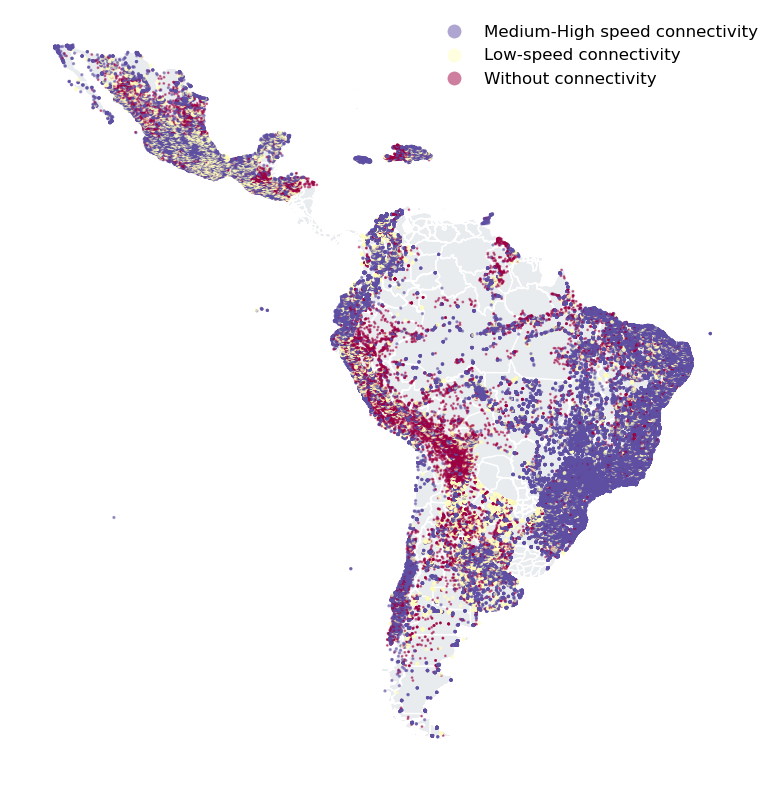

In [39]:
# Temporary variable
var_ = "avg_d_mbps_fix"
vmin = 10
cats = ["Medium-High speed connectivity","Low-speed connectivity","Without connectivity"]

fhealthinfra["ftemp"] = np.where(fhealthinfra[var_].isna() , cats[2], "")
fhealthinfra["ftemp"] = np.where(fhealthinfra[var_] <= vmin, cats[1], fhealthinfra.ftemp)
fhealthinfra["ftemp"] = np.where(fhealthinfra[var_] >  vmin, cats[0], fhealthinfra.ftemp)
fhealthinfra["ftemp"] = pd.Categorical(fhealthinfra["ftemp"], categories = cats, ordered = True)

fhealthinfra["size_"] = np.where(fhealthinfra.ftemp == cats[2],1,0)
fhealthinfra["size_"] = np.where(fhealthinfra.ftemp == cats[1],4,fhealthinfra.size_)
fhealthinfra["size_"] = np.where(fhealthinfra.ftemp == cats[0],2,fhealthinfra.size_)

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth = 1, edgecolor = "white")
fhealthinfra.plot(ax = ax, column = "ftemp", cmap = "Spectral_r", categorical = True, legend = True, alpha = 0.5, markersize = "size_", legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.axis("off")
plt.show()

In [40]:
# Results 
main_ = fhealthinfra.ftemp.value_counts(dropna = False).reset_index()
main_ = main_.rename(columns = {"count":'# health centers'})
main_["% health centers"] = main_["# health centers"] * 100 / main_["# health centers"].sum()
low_high = main_[main_["ftemp"].isin(cats[:2])]["# health centers"].sum()
low_per  = main_[main_["ftemp"].isin(cats[1:2])]["# health centers"].sum() / low_high

print(main_)
print(" ")
print(f"Number of healthcenters with low-high speed: {low_high:,} of which {low_per*100:.1f}% have low-speed")

print(f"\nSource: Health centers from {healthinfra_lab} and connectivity data from Ookla Open Data Initiative, data from 2023-Q2")
print(f"Notes: A health center is considered to have low and high connectivity if the average download level is less than 15 mbps.")

                            ftemp  # health centers  % health centers
0  Medium-High speed connectivity            222718         89.517960
1            Without connectivity             16341          6.568005
2          Low-speed connectivity              9738          3.914034
 
Number of healthcenters with low-high speed: 232,456 of which 4.2% have low-speed

Source: Health centers from official records and connectivity data from Ookla Open Data Initiative, data from 2023-Q2
Notes: A health center is considered to have low and high connectivity if the average download level is less than 15 mbps.


## 6. Table & Figures

### Results by country

In [41]:
# Define thresholds
thresh_ = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]

# Initialize an empty dataframe to store the results
result = pd.DataFrame()
result['Total']      = fhealthinfra.groupby('isoalpha3').size()
result['avg_mob_NA'] = fhealthinfra[fhealthinfra['avg_d_mbps_mob'].isna() | (fhealthinfra['avg_d_mbps_mob'] <= 0)].groupby('isoalpha3').size()
result['avg_fix_NA'] = fhealthinfra[fhealthinfra['avg_d_mbps_fix'].isna() | (fhealthinfra['avg_d_mbps_fix'] <= 0)].groupby('isoalpha3').size()

# Mobile bythreshold
for threshold in thresh_:
    col_name_mob = f'avg_mob_{threshold}'
    result[col_name_mob] = fhealthinfra[fhealthinfra['avg_d_mbps_mob'] <= threshold].groupby('isoalpha3').size()

# Fixed by treshold
for threshold in thresh_:
    col_name_fix = f'avg_fix_{threshold}'
    result[col_name_fix] = fhealthinfra[fhealthinfra['avg_d_mbps_fix'] <= threshold].groupby('isoalpha3').size()

# Fill NAs values with 0
result = result.fillna(0).astype(int)

# Calculate the percentage of total health centers for each threshold
result_per = result.div(result['Total'], axis=0) * 100

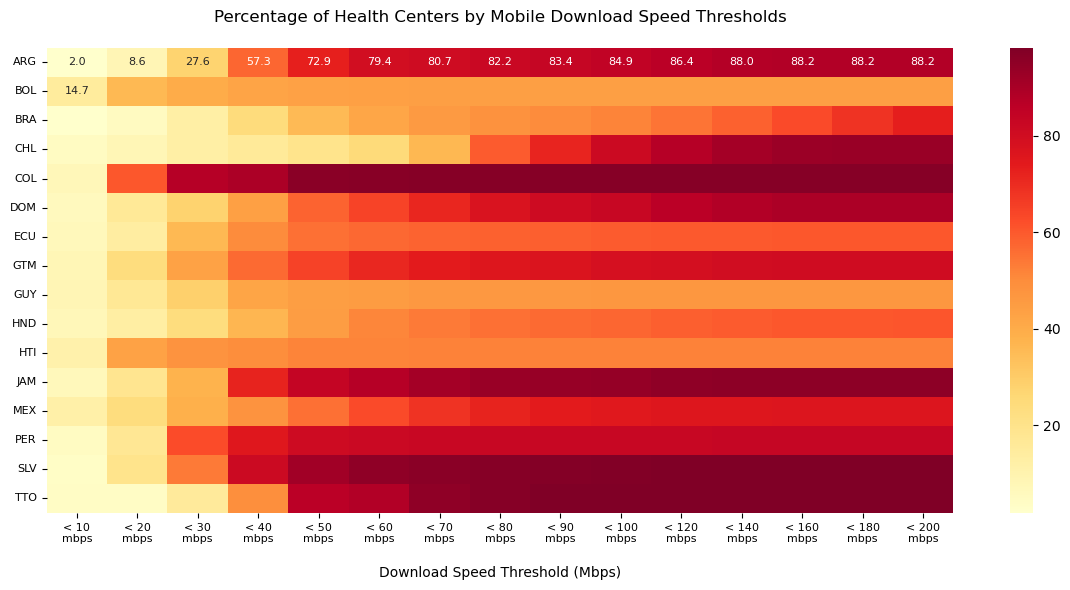

In [56]:
# Mobile 
mob_columns = [f'avg_mob_{threshold}' for threshold in thresh_]
mob_labels  = [f'< {threshold}\nmbps' for threshold in thresh_]
mob_data    = result_per[mob_columns]
annotations = mob_data.map(lambda x: f'{x:.1f}' if not pd.isna(x) else '')

fig, ax = plt.subplots(1, figsize = (12,6))
sns.heatmap(mob_data, annot = annotations, fmt = '', cmap = 'YlOrRd', ax = ax, xticklabels = mob_labels, annot_kws = {"size": 8})
ax.set_title('Percentage of Health Centers by Mobile Download Speed Thresholds\n')
ax.set_ylabel('')
ax.set_xlabel('\nDownload Speed Threshold (Mbps)')
ax.tick_params(axis = 'y', labelsize=8)
ax.tick_params(axis = 'x', labelsize=8, rotation = 0)
plt.tight_layout()
plt.show()

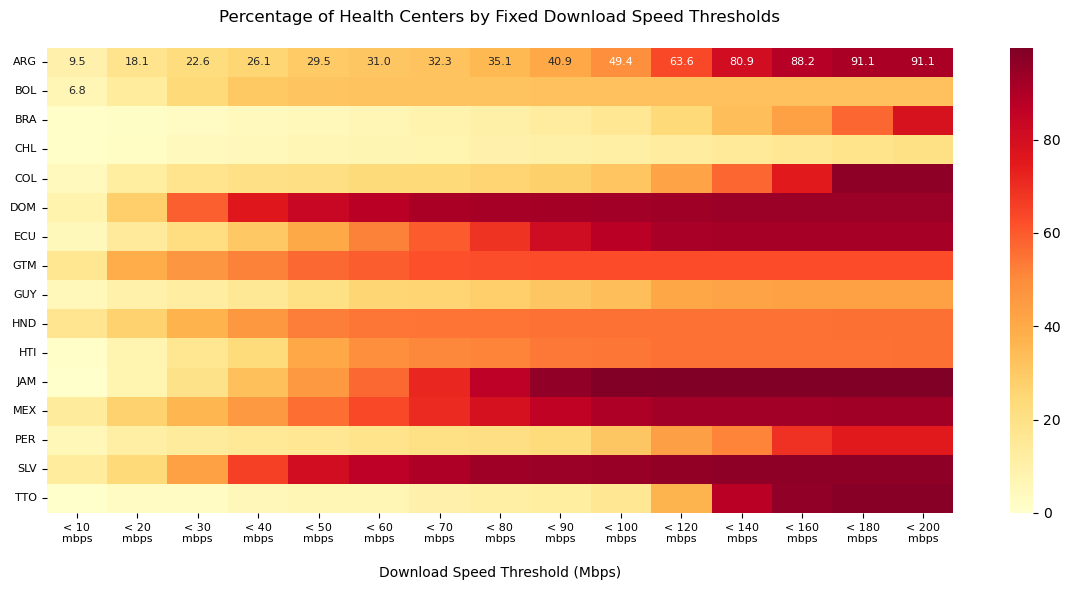

In [57]:
# Fixed 
fix_columns = [f'avg_fix_{threshold}' for threshold in thresh_]
fix_labels  = [f'< {threshold}\nmbps' for threshold in thresh_]
fix_data    = result_per[fix_columns]
annotations = fix_data.map(lambda x: f'{x:.1f}' if not pd.isna(x) else '')

fig, ax = plt.subplots(1, figsize = (12,6))
sns.heatmap(fix_data, annot = annotations, fmt = '', cmap = 'YlOrRd', ax = ax, xticklabels = mob_labels, annot_kws = {"size": 8})
ax.set_title('Percentage of Health Centers by Fixed Download Speed Thresholds\n')
ax.set_ylabel('')
ax.set_xlabel('\nDownload Speed Threshold (Mbps)')
ax.tick_params(axis = 'y', labelsize=8)
ax.tick_params(axis = 'x', labelsize=8, rotation = 0)
plt.tight_layout()
plt.show()